By [Kevin Michalewicz](https://kevinmichalewicz.com) on April 2023

This notebook details how to pre-process antibody structures to obtain aligned normal mode correlation maps. After that, training and evaluation using the ANTIPASTI model is explained.

In [1]:
# General imports
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import math
import optuna

from matplotlib.colors import CenteredNorm
from random import randint
from sklearn.model_selection import KFold

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief
from torch.nn import MSELoss
from torchmetrics import PearsonCorrCoef

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import plot_map_with_regions
from antipasti.utils.torch_utils import create_test_set, save_checkpoint, training_routine

# Pre-processing

In [2]:
modes = 'all' # Number of normal modes to consider. Relevant if renew_maps is True
renew_maps = False # True to compute again all the normal mode correlation maps
renew_residues = False # True to retrieve again all the chain lengths 
dccm_map_path = 'dccm_maps_full_ags_all/' # NM correlation maps or contact maps are saved here
ag_agnostic = False # If True, only the antibody is considered
contact_maps = False # True to compute contact maps and False to compute NM correlation maps
cmaps_thr = 8.0 # If contact_maps is True, then this is the thresholding parameter, otherwise irrelevant. If 'all', distance matrices are generated

pathological = ['5omm', '5i5k', '1uwx', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t', '3fku', '1oau', '1oay']
scfv = ['4gqp', '3etb', '3gkz', '3uze', '3uzq', '3gm0', '4f9l', '6ejg', '6ejm', '1h8s', '5dfw', '6cbp', '4f9p', '5kov', '1dzb', '5j74', '5aaw', '3uzv', '5aam', '3ux9', '5a2j', '5a2k', '5a2i', '3fku', '5yy4', '3uyp', '5jyl', '1y0l', '1p4b', '3kdm', '4lar', '4ffy', '2ybr', '1mfa', '5xj3', '5xj4', '4kv5', '5vyf'] 
pathological += scfv

preprocessed_data = Preprocessing(dccm_map_path=dccm_map_path, modes=modes, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, ag_agnostic=ag_agnostic, cmaps=contact_maps, cmaps_thr=cmaps_thr)

In [3]:
preprocessed_data.train_x.shape

(634, 292, 292)

Let's plot some histograms to see the distributions of the chain lengths and the binding affinities.

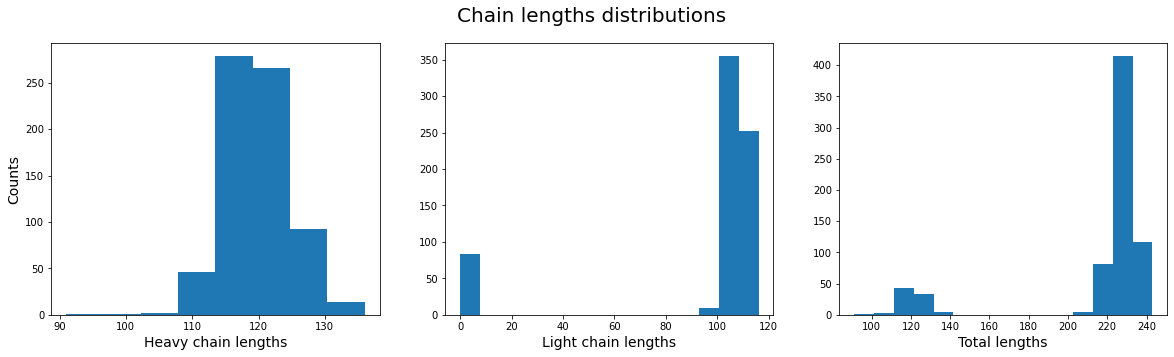

In [4]:
title_size = 20
font_size = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Chain lengths distributions', size=title_size)
ax1.hist(preprocessed_data.heavy, 8)
ax2.hist(preprocessed_data.light, 15)
ax3.hist([sum(x) for x in zip(preprocessed_data.heavy, preprocessed_data.light)], 15)

# Changing plotting settings
ax1.set_ylabel('Counts', size=font_size)
ax1.set_xlabel('Heavy chain lengths', size=font_size)
ax2.set_xlabel('Light chain lengths', size=font_size)
ax3.set_xlabel('Total lengths', size=font_size)

plt.show()

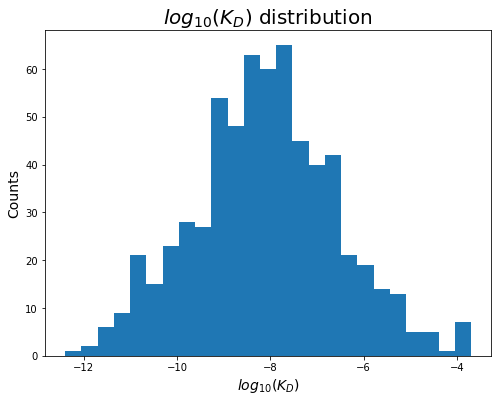

In [5]:
fig = plt.figure(figsize=(8, 6))
plt.title('$log_{10}(K_D)$ distribution', size=title_size)
plt.hist(preprocessed_data.train_y, 25)
plt.xlabel('$log_{10}(K_D)$', size=font_size)
plt.ylabel('Counts', size=font_size)
plt.show()

A sample normal mode correlation map before and after adding the blank pixels.

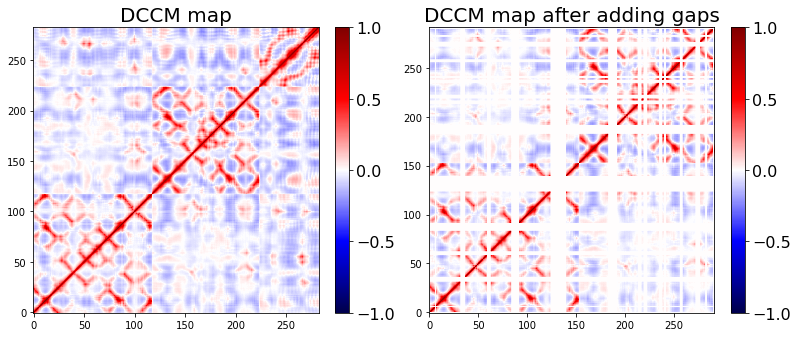

In [6]:
input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[304], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[304].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

cb1 = plt.colorbar(im1, ax=ax1, fraction=0.045)
cb2 = plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
cb1.ax.tick_params(labelsize=16) 
cb2.ax.tick_params(labelsize=16) 

plt.show()

In [7]:
# The test set is generated
random_seed = randint(0, 1000)
train_x, test_x, train_y, test_y, idx_tr, idx_te = create_test_set(preprocessed_data.train_x, preprocessed_data.train_y, test_size=0.05, random_state=random_seed)

In [8]:
# Optimal hyperparameters
n_filters = 4
filter_size = 4
pooling_size = 2
learning_rate = 1e-4


# Defining the model, optimiser and loss function
model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape, l1_lambda=0.002)
criterion = MSELoss() 
optimiser = AdaBelief(model.parameters(), lr=learning_rate, weight_decay=False, eps=1e-8, print_change_log=False) 
print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
ANTIPASTI(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=82944, out_features=1, bias=False)
)


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

83012

In [10]:
train_losses = []
test_losses = []

In [11]:
model.train()
n_max_epochs = 50 # This is just a super short example. You can increase this.
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor(0.3049, grad_fn=<MulBackward0>)
tensor(0.3099, grad_fn=<MulBackward0>)
tensor(0.3132, grad_fn=<MulBackward0>)
tensor(0.3122, grad_fn=<MulBackward0>)
tensor(0.3103, grad_fn=<MulBackward0>)
tensor(0.3088, grad_fn=<MulBackward0>)
tensor(0.3088, grad_fn=<MulBackward0>)
tensor(0.3087, grad_fn=<MulBackward0>)
tensor(0.3086, grad_fn=<MulBackward0>)
tensor(0.3085, grad_fn=<MulBackward0>)
tensor(0.3083, grad_fn=<MulBackward0>)
tensor(0.3082, grad_fn=<MulBackward0>)
tensor(0.3081, grad_fn=<MulBackward0>)
tensor(0.3079, grad_fn=<MulBackward0>)
tensor(0.3078, grad_fn=<MulBackward0>)
tensor(0.3076, grad_fn=<MulBackward0>)
tensor(0.3075, grad_fn=<MulBackward0>)
tensor(0.3073, grad_fn=<MulBackward0>)
tensor(0.3071, grad_fn=<MulBackward0>)
tensor(0.3070, grad_fn=<MulBackward0>)
tensor([[-6.7731]])
tensor([[-6.4202]])
------------------------
tensor([[-6.4101]])
tensor([[-7.1427]])
------------------------
tensor([[-5.7510]])
tensor([[-8.0506]])
------------------------
tensor([[-7.3637]])
tenso

tensor(0.2874, grad_fn=<MulBackward0>)
tensor(0.2869, grad_fn=<MulBackward0>)
tensor(0.2865, grad_fn=<MulBackward0>)
tensor(0.2861, grad_fn=<MulBackward0>)
tensor(0.2857, grad_fn=<MulBackward0>)
tensor(0.2853, grad_fn=<MulBackward0>)
tensor(0.2849, grad_fn=<MulBackward0>)
tensor(0.2845, grad_fn=<MulBackward0>)
tensor(0.2840, grad_fn=<MulBackward0>)
tensor(0.2836, grad_fn=<MulBackward0>)
tensor(0.2832, grad_fn=<MulBackward0>)
tensor(0.2828, grad_fn=<MulBackward0>)
tensor(0.2824, grad_fn=<MulBackward0>)
tensor(0.2820, grad_fn=<MulBackward0>)
tensor(0.2816, grad_fn=<MulBackward0>)
tensor(0.2812, grad_fn=<MulBackward0>)
tensor(0.2808, grad_fn=<MulBackward0>)
tensor(0.2804, grad_fn=<MulBackward0>)
tensor(0.2799, grad_fn=<MulBackward0>)
tensor(0.2795, grad_fn=<MulBackward0>)
tensor([[-7.8288]])
tensor([[-6.4202]])
------------------------
tensor([[-7.5942]])
tensor([[-7.1427]])
------------------------
tensor([[-6.7088]])
tensor([[-8.0506]])
------------------------
tensor([[-8.2854]])
tenso

tensor(0.2550, grad_fn=<MulBackward0>)
tensor(0.2547, grad_fn=<MulBackward0>)
tensor(0.2543, grad_fn=<MulBackward0>)
tensor(0.2540, grad_fn=<MulBackward0>)
tensor(0.2537, grad_fn=<MulBackward0>)
tensor(0.2534, grad_fn=<MulBackward0>)
tensor(0.2530, grad_fn=<MulBackward0>)
tensor(0.2527, grad_fn=<MulBackward0>)
tensor(0.2523, grad_fn=<MulBackward0>)
tensor(0.2520, grad_fn=<MulBackward0>)
tensor(0.2516, grad_fn=<MulBackward0>)
tensor(0.2513, grad_fn=<MulBackward0>)
tensor(0.2510, grad_fn=<MulBackward0>)
tensor(0.2507, grad_fn=<MulBackward0>)
tensor(0.2504, grad_fn=<MulBackward0>)
tensor(0.2501, grad_fn=<MulBackward0>)
tensor(0.2498, grad_fn=<MulBackward0>)
tensor(0.2495, grad_fn=<MulBackward0>)
tensor(0.2493, grad_fn=<MulBackward0>)
tensor([[-7.6888]])
tensor([[-6.4202]])
------------------------
tensor([[-7.8704]])
tensor([[-7.1427]])
------------------------
tensor([[-7.2928]])
tensor([[-8.0506]])
------------------------
tensor([[-8.2588]])
tensor([[-7.0362]])
------------------------

tensor([[-8.1184]])
tensor([[-11.2218]])
------------------------
Epoch :  12 	 train loss:  2.5662013658511094 train MSE:  tensor(2.3155, grad_fn=<AddBackward0>) test MSE:  2.509422795647548
Corr: 0.7155050047172941
tensor(0.2389, grad_fn=<MulBackward0>)
tensor(0.2388, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2386, grad_fn=<MulBackward0>)
tensor(0.2386, grad_fn=<MulBackward0>)
tensor(0.2386, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
tensor(0.2387, grad_fn=<MulBackward0>)
ten

tensor(0.2381, grad_fn=<MulBackward0>)
tensor(0.2381, grad_fn=<MulBackward0>)
tensor(0.2382, grad_fn=<MulBackward0>)
tensor(0.2382, grad_fn=<MulBackward0>)
tensor(0.2383, grad_fn=<MulBackward0>)
tensor(0.2383, grad_fn=<MulBackward0>)
tensor(0.2383, grad_fn=<MulBackward0>)
tensor(0.2383, grad_fn=<MulBackward0>)
tensor(0.2382, grad_fn=<MulBackward0>)
tensor(0.2381, grad_fn=<MulBackward0>)
tensor(0.2380, grad_fn=<MulBackward0>)
tensor(0.2379, grad_fn=<MulBackward0>)
tensor(0.2378, grad_fn=<MulBackward0>)
tensor(0.2377, grad_fn=<MulBackward0>)
tensor(0.2376, grad_fn=<MulBackward0>)
tensor(0.2375, grad_fn=<MulBackward0>)
tensor(0.2375, grad_fn=<MulBackward0>)
tensor(0.2374, grad_fn=<MulBackward0>)
tensor(0.2375, grad_fn=<MulBackward0>)
tensor([[-7.1541]])
tensor([[-6.4202]])
------------------------
tensor([[-7.9651]])
tensor([[-7.1427]])
------------------------
tensor([[-8.1350]])
tensor([[-8.0506]])
------------------------
tensor([[-8.1431]])
tensor([[-7.0362]])
------------------------

tensor(0.2366, grad_fn=<MulBackward0>)
tensor(0.2365, grad_fn=<MulBackward0>)
tensor(0.2364, grad_fn=<MulBackward0>)
tensor(0.2364, grad_fn=<MulBackward0>)
tensor(0.2365, grad_fn=<MulBackward0>)
tensor(0.2365, grad_fn=<MulBackward0>)
tensor(0.2366, grad_fn=<MulBackward0>)
tensor(0.2367, grad_fn=<MulBackward0>)
tensor(0.2368, grad_fn=<MulBackward0>)
tensor(0.2370, grad_fn=<MulBackward0>)
tensor(0.2371, grad_fn=<MulBackward0>)
tensor(0.2371, grad_fn=<MulBackward0>)
tensor(0.2371, grad_fn=<MulBackward0>)
tensor(0.2371, grad_fn=<MulBackward0>)
tensor(0.2370, grad_fn=<MulBackward0>)
tensor(0.2369, grad_fn=<MulBackward0>)
tensor(0.2368, grad_fn=<MulBackward0>)
tensor(0.2366, grad_fn=<MulBackward0>)
tensor(0.2364, grad_fn=<MulBackward0>)
tensor([[-7.2875]])
tensor([[-6.4202]])
------------------------
tensor([[-8.1616]])
tensor([[-7.1427]])
------------------------
tensor([[-8.6448]])
tensor([[-8.0506]])
------------------------
tensor([[-8.4333]])
tensor([[-7.0362]])
------------------------

tensor(0.2349, grad_fn=<MulBackward0>)
tensor(0.2347, grad_fn=<MulBackward0>)
tensor(0.2347, grad_fn=<MulBackward0>)
tensor(0.2346, grad_fn=<MulBackward0>)
tensor(0.2345, grad_fn=<MulBackward0>)
tensor(0.2344, grad_fn=<MulBackward0>)
tensor(0.2343, grad_fn=<MulBackward0>)
tensor(0.2343, grad_fn=<MulBackward0>)
tensor(0.2343, grad_fn=<MulBackward0>)
tensor(0.2343, grad_fn=<MulBackward0>)
tensor(0.2343, grad_fn=<MulBackward0>)
tensor(0.2344, grad_fn=<MulBackward0>)
tensor(0.2344, grad_fn=<MulBackward0>)
tensor(0.2344, grad_fn=<MulBackward0>)
tensor(0.2344, grad_fn=<MulBackward0>)
tensor(0.2344, grad_fn=<MulBackward0>)
tensor(0.2343, grad_fn=<MulBackward0>)
tensor(0.2343, grad_fn=<MulBackward0>)
tensor(0.2341, grad_fn=<MulBackward0>)
tensor(0.2340, grad_fn=<MulBackward0>)
tensor([[-7.2348]])
tensor([[-6.4202]])
------------------------
tensor([[-8.1056]])
tensor([[-7.1427]])
------------------------
tensor([[-8.6699]])
tensor([[-8.0506]])
------------------------
tensor([[-8.4588]])
tenso

Corr: 0.6996754507980063
tensor(0.2317, grad_fn=<MulBackward0>)
tensor(0.2316, grad_fn=<MulBackward0>)
tensor(0.2315, grad_fn=<MulBackward0>)
tensor(0.2315, grad_fn=<MulBackward0>)
tensor(0.2315, grad_fn=<MulBackward0>)
tensor(0.2315, grad_fn=<MulBackward0>)
tensor(0.2315, grad_fn=<MulBackward0>)
tensor(0.2316, grad_fn=<MulBackward0>)
tensor(0.2317, grad_fn=<MulBackward0>)
tensor(0.2318, grad_fn=<MulBackward0>)
tensor(0.2319, grad_fn=<MulBackward0>)
tensor(0.2319, grad_fn=<MulBackward0>)
tensor(0.2318, grad_fn=<MulBackward0>)
tensor(0.2317, grad_fn=<MulBackward0>)
tensor(0.2317, grad_fn=<MulBackward0>)
tensor(0.2316, grad_fn=<MulBackward0>)
tensor(0.2315, grad_fn=<MulBackward0>)
tensor(0.2314, grad_fn=<MulBackward0>)
tensor(0.2314, grad_fn=<MulBackward0>)
tensor(0.2314, grad_fn=<MulBackward0>)
tensor([[-7.3143]])
tensor([[-6.4202]])
------------------------
tensor([[-8.1846]])
tensor([[-7.1427]])
------------------------
tensor([[-8.7672]])
tensor([[-8.0506]])
------------------------


tensor([[-8.2804]])
tensor([[-11.2218]])
------------------------
Epoch :  32 	 train loss:  2.2725167118645966 train MSE:  tensor(2.0321, grad_fn=<AddBackward0>) test MSE:  2.1490281872789967
Corr: 0.6963120535336127
tensor(0.2290, grad_fn=<MulBackward0>)
tensor(0.2290, grad_fn=<MulBackward0>)
tensor(0.2290, grad_fn=<MulBackward0>)
tensor(0.2290, grad_fn=<MulBackward0>)
tensor(0.2290, grad_fn=<MulBackward0>)
tensor(0.2291, grad_fn=<MulBackward0>)
tensor(0.2291, grad_fn=<MulBackward0>)
tensor(0.2292, grad_fn=<MulBackward0>)
tensor(0.2292, grad_fn=<MulBackward0>)
tensor(0.2292, grad_fn=<MulBackward0>)
tensor(0.2292, grad_fn=<MulBackward0>)
tensor(0.2290, grad_fn=<MulBackward0>)
tensor(0.2289, grad_fn=<MulBackward0>)
tensor(0.2288, grad_fn=<MulBackward0>)
tensor(0.2286, grad_fn=<MulBackward0>)
tensor(0.2285, grad_fn=<MulBackward0>)
tensor(0.2285, grad_fn=<MulBackward0>)
tensor(0.2286, grad_fn=<MulBackward0>)
tensor(0.2287, grad_fn=<MulBackward0>)
tensor(0.2287, grad_fn=<MulBackward0>)
te

tensor([[-8.6581]])
tensor([[-7.0362]])
------------------------
tensor([[-8.5934]])
tensor([[-9.2733]])
------------------------
tensor([[-7.4886]])
tensor([[-8.1643]])
------------------------
tensor([[-7.3041]])
tensor([[-7.9208]])
------------------------
tensor([[-7.5429]])
tensor([[-6.8386]])
------------------------
tensor([[-9.0564]])
tensor([[-11.2441]])
------------------------
tensor([[-7.5497]])
tensor([[-7.8539]])
------------------------
tensor([[-7.4001]])
tensor([[-5.3098]])
------------------------
tensor([[-7.4155]])
tensor([[-5.8327]])
------------------------
tensor([[-8.5875]])
tensor([[-9.7905]])
------------------------
tensor([[-7.2370]])
tensor([[-7.6021]])
------------------------
tensor([[-7.2806]])
tensor([[-6.6198]])
------------------------
tensor([[-8.3162]])
tensor([[-11.3010]])
------------------------
tensor([[-8.4176]])
tensor([[-8.0044]])
------------------------
tensor([[-8.4272]])
tensor([[-8.8539]])
------------------------
tensor([[-7.3003]])
ten

tensor([[-8.6332]])
tensor([[-11.3979]])
------------------------
tensor([[-8.3834]])
tensor([[-11.2218]])
------------------------
Epoch :  39 	 train loss:  2.3593856649461133 train MSE:  tensor(2.1240, grad_fn=<AddBackward0>) test MSE:  2.096628463403745
Corr: 0.7078580706340328
tensor(0.2244, grad_fn=<MulBackward0>)
tensor(0.2244, grad_fn=<MulBackward0>)
tensor(0.2245, grad_fn=<MulBackward0>)
tensor(0.2245, grad_fn=<MulBackward0>)
tensor(0.2245, grad_fn=<MulBackward0>)
tensor(0.2246, grad_fn=<MulBackward0>)
tensor(0.2246, grad_fn=<MulBackward0>)
tensor(0.2245, grad_fn=<MulBackward0>)
tensor(0.2243, grad_fn=<MulBackward0>)
tensor(0.2243, grad_fn=<MulBackward0>)
tensor(0.2242, grad_fn=<MulBackward0>)
tensor(0.2242, grad_fn=<MulBackward0>)
tensor(0.2241, grad_fn=<MulBackward0>)
tensor(0.2241, grad_fn=<MulBackward0>)
tensor(0.2241, grad_fn=<MulBackward0>)
tensor(0.2240, grad_fn=<MulBackward0>)
tensor(0.2240, grad_fn=<MulBackward0>)
tensor(0.2240, grad_fn=<MulBackward0>)
tensor(0.2240, 

tensor(0.2226, grad_fn=<MulBackward0>)
tensor(0.2228, grad_fn=<MulBackward0>)
tensor(0.2230, grad_fn=<MulBackward0>)
tensor(0.2231, grad_fn=<MulBackward0>)
tensor(0.2233, grad_fn=<MulBackward0>)
tensor(0.2232, grad_fn=<MulBackward0>)
tensor(0.2231, grad_fn=<MulBackward0>)
tensor(0.2231, grad_fn=<MulBackward0>)
tensor(0.2230, grad_fn=<MulBackward0>)
tensor(0.2228, grad_fn=<MulBackward0>)
tensor(0.2226, grad_fn=<MulBackward0>)
tensor(0.2224, grad_fn=<MulBackward0>)
tensor(0.2223, grad_fn=<MulBackward0>)
tensor(0.2222, grad_fn=<MulBackward0>)
tensor(0.2222, grad_fn=<MulBackward0>)
tensor(0.2223, grad_fn=<MulBackward0>)
tensor(0.2223, grad_fn=<MulBackward0>)
tensor(0.2224, grad_fn=<MulBackward0>)
tensor(0.2224, grad_fn=<MulBackward0>)
tensor(0.2224, grad_fn=<MulBackward0>)
tensor([[-7.2390]])
tensor([[-6.4202]])
------------------------
tensor([[-8.1558]])
tensor([[-7.1427]])
------------------------
tensor([[-8.6976]])
tensor([[-8.0506]])
------------------------
tensor([[-8.6704]])
tenso

tensor(0.2202, grad_fn=<MulBackward0>)
tensor(0.2200, grad_fn=<MulBackward0>)
tensor(0.2199, grad_fn=<MulBackward0>)
tensor(0.2200, grad_fn=<MulBackward0>)
tensor(0.2200, grad_fn=<MulBackward0>)
tensor(0.2200, grad_fn=<MulBackward0>)
tensor(0.2199, grad_fn=<MulBackward0>)
tensor(0.2198, grad_fn=<MulBackward0>)
tensor(0.2198, grad_fn=<MulBackward0>)
tensor(0.2197, grad_fn=<MulBackward0>)
tensor(0.2196, grad_fn=<MulBackward0>)
tensor(0.2195, grad_fn=<MulBackward0>)
tensor(0.2194, grad_fn=<MulBackward0>)
tensor(0.2195, grad_fn=<MulBackward0>)
tensor(0.2196, grad_fn=<MulBackward0>)
tensor(0.2197, grad_fn=<MulBackward0>)
tensor(0.2197, grad_fn=<MulBackward0>)
tensor(0.2198, grad_fn=<MulBackward0>)
tensor(0.2198, grad_fn=<MulBackward0>)
tensor([[-7.4687]])
tensor([[-6.4202]])
------------------------
tensor([[-8.2732]])
tensor([[-7.1427]])
------------------------
tensor([[-8.9603]])
tensor([[-8.0506]])
------------------------
tensor([[-8.9099]])
tensor([[-7.0362]])
------------------------

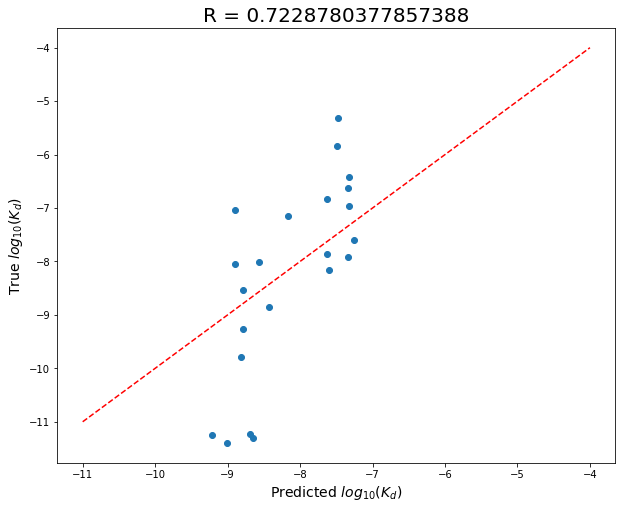

In [12]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.array(output_test), y_test[:,0].detach().numpy())
corr = np.corrcoef(np.array(output_test).T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

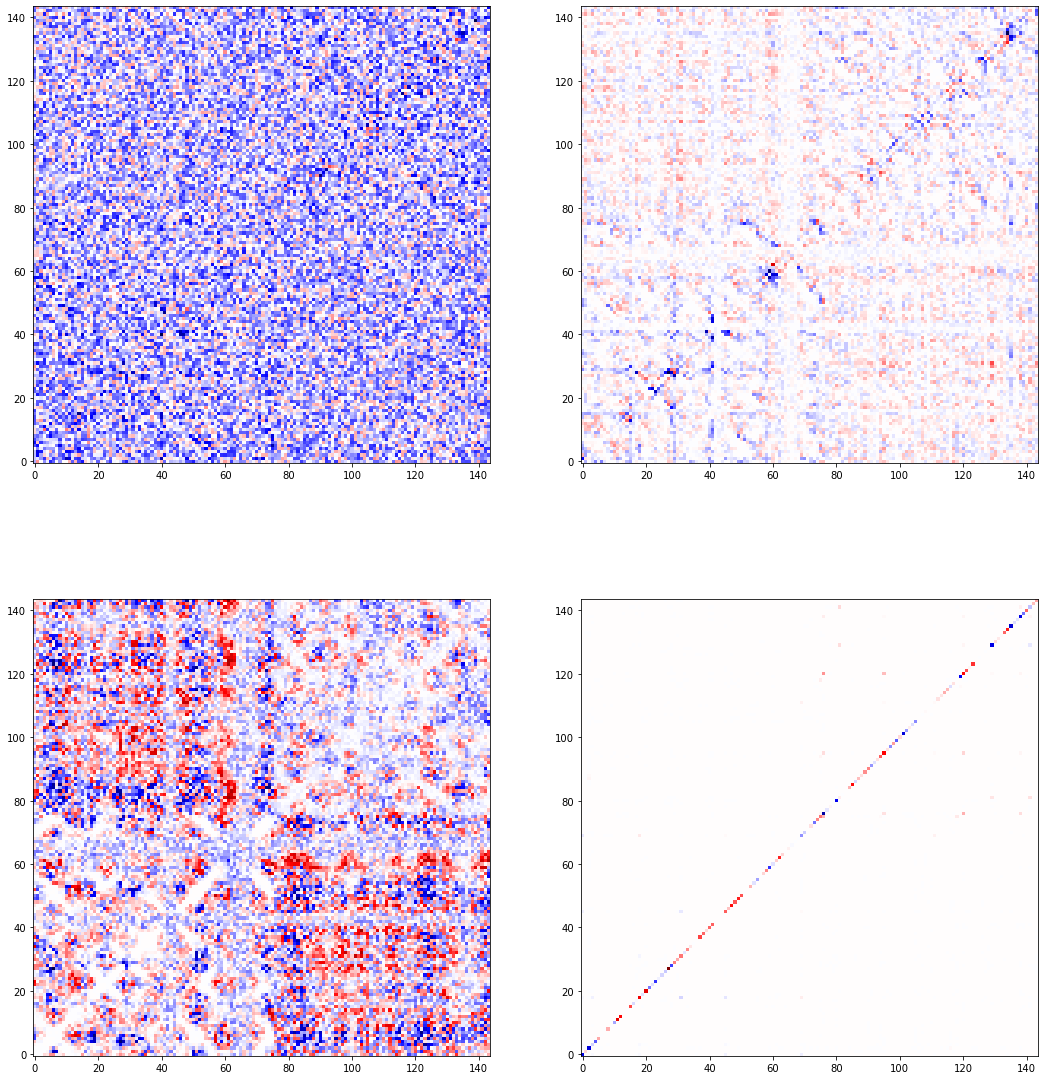

In [13]:
fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(18, 20))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
learnt_filter = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = learnt_filter
    else:
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        learnt_filter += im_
    im = axs[i,j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())

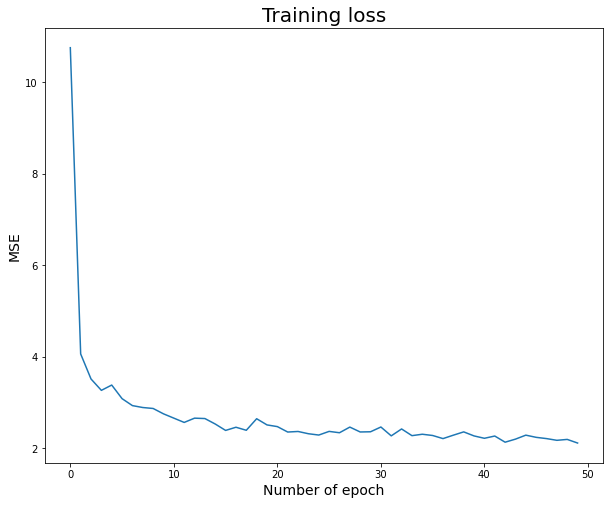

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

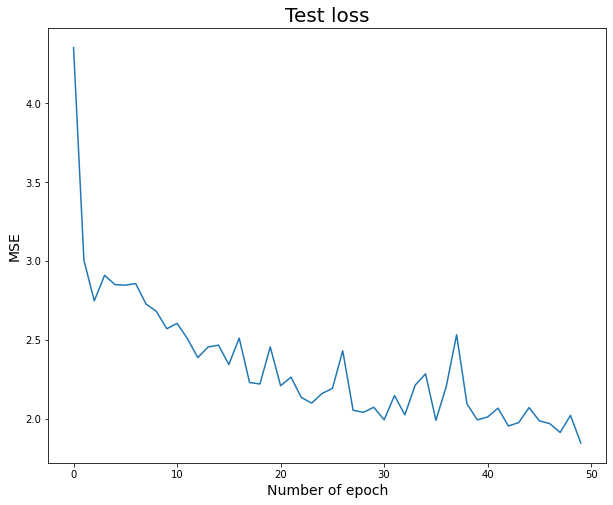

In [15]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i] for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

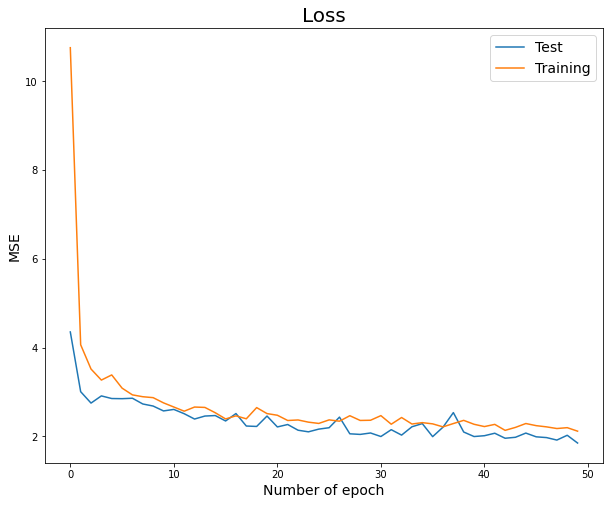

In [16]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[:][i] for i in range(len(test_losses[:]))])
plt.plot([train_losses[:][i] for i in range(len(train_losses[:]))])
plt.title('Loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.legend(['Test', 'Training'], prop={'size': font_size})
plt.show()

# Checkpoints

In [ ]:
##### Uncomment the following lines to save a checkpoint

#path = '../checkpoints/model_epochs_' + str(len(train_losses)) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
#save_checkpoint(path, model, optimiser, train_losses, test_losses)
#np.save('../checkpoints/learnt_filter_epochs_'+str(len(train_losses))+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy', learnt_filter)

In [ ]:
##### Uncomment the following lines to load a checkpoint

#from antipasti.utils.torch_utils import load_checkpoint
#
#nf_chckpt = 
#pool_chckpt = 
#k_chckpt = 
#ep_chckpt = 
#modes_chckpt = 
#input_shape = 

#path = '../checkpoints/.../model_epochs_' + str(ep_chckpt) + '_modes_' + str(modes_chckpt) + '_pool_' + str(pool_chckpt) + '_filters_' + str(nf_chckpt) + '_size_' + str(k_chckpt) + '.pt'
#model,optimiser,_,train_losses, test_losses = load_checkpoint(path, input_shape)

## Hyperparametric search

In [ ]:
n_max_epochs = 1000 # Your value
max_corr = 0.87
batch_size = 32

def objective(trial):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    
    n_filters = trial.suggest_categorical('n_filters', [2, 4, 8])
    filter_size = trial.suggest_int('filter_size', 3, 5)
    pooling_size = trial.suggest_int('pooling_size', 1, 3)
    learning_rate = trial.suggest_categorical('learning_rate', [5e-5, 1e-5, 4e-5, 1e-5])
    print('Filters:')
    print(n_filters)
    print('with size:')
    print(filter_size)
    print('Pooling size:')
    print(pooling_size)
    print('Learning rate:')
    print(learning_rate)
    fold = 0
    
    for train_index, val_index in kf.split(train_x):
        fold += 1
        train_loss = [100]
        val_loss = [100]
        train_x_fold, val_x_fold = train_x[train_index], train_x[val_index]
        train_y_fold, val_y_fold = train_y[train_index], train_y[val_index].reshape(val_x_fold.shape[0], 1, 1)          

        while val_loss[-1] > 5 or (val_loss[-1] > 2 and n_filters == 4 and filter_size == 4):
            model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape, l1_lambda=0.002)
            criterion = MSELoss() 
            optimiser = AdaBelief(model.parameters(), lr=learning_rate, weight_decay=False, eps=1e-8, print_change_log=False) 
            train_loss, val_loss, _, _, _ = training_routine(model, criterion, optimiser, train_x_fold, val_x_fold, train_y_fold, val_y_fold, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size, verbose=False)

        print('Fold number')
        print(fold)            
        
        for i in range(20):
            previous_val_loss = np.mean(val_loss)
            if np.mean(val_loss) <= 1.2*np.mean(train_loss) and np.mean(val_loss) < 1.2*previous_val_loss and math.isnan(val_loss[-1]) == False:
                train_loss, val_loss, _, _, _ = training_routine(model, criterion, optimiser, train_x_fold, val_x_fold, train_y_fold, val_y_fold, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size, verbose=False)
                print(np.mean(val_loss))
                print(np.mean(train_loss))

        scores.append(np.mean(val_loss))
        print(f'Score for fold {fold}')
        print(scores)
        
    return np.mean(np.array(scores))


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))